**Step Process Data Analysis**

While we won't be able to log data and add print statements to vLLM in production code, an initial data analysis of how scheduling, executiong, and post processing times scale is relevant to understand where time of execution varies the most

(In vLLM core.py)
```python
        timestart = time.time()
        ### Scheduling Phase
        if not self.scheduler.has_requests():
            return {}, False
        scheduler_output = self.scheduler.schedule()
        ### End of Scheduling Phase
        timeend = time.time()
        scheduler_time = timeend - timestart



        timestart = time.time()
        ### Execution Phase
        model_output = self.execute_model(scheduler_output)
        ### End of Execution Phase
        timeend = time.time()
        execute_time = timeend - timestart

        timestart = time.time()
        ### Post-processing Phase
        engine_core_outputs = self.scheduler.update_from_output(
            scheduler_output, model_output)  # type: ignore
        ### End of Post-processing Phase
        timeend = time.time()
        update_time = timeend - timestart
```

We store the results in a csv for processing (execution_stats.csv)

In [9]:
# load csv in pandas
import pandas as pd

file_path = 'execution_stats.csv'
df = pd.read_csv(file_path)
df.head()

,num_scheduled_tokens,num_total_scheduled_tokens,scheduled_new_reqs,execute_time,scheduler_time,update_time
0,{'cmpl-60b599c90085488093f9f1399f391400-0': 1},1,[],0.002067,0.000028,0.000029
1,{'cmpl-60b599c90085488093f9f1399f391400-0': 1},1,[],0.002111,0.000030,0.000029
2,{'cmpl-60b599c90085488093f9f1399f391400-0': 1},1,[],0.002122,0.000029,0.000030
3,{'cmpl-60b599c90085488093f9f1399f391400-0': 1},1,[],0.002060,0.000027,0.000030
4,{'cmpl-60b599c90085488093f9f1399f391400-0': 1},1,[],0.002029,0.000028,0.000028


In [16]:
# average update_time and scheduler_time
avg_update_time = df['update_time'].mean()
avg_scheduler_time = df['scheduler_time'].mean()
print(f"Average update_time: {avg_update_time}")
print(f"Average scheduler_time: {avg_scheduler_time}")

Average update_time: 0.00015462176348014274
Average scheduler_time: 0.00025143369338996607


In [15]:
# for each iteration get the percentage of the execute_time, scheduler_time, and update_time over the total time (total_time = execute_time + scheduler_time + update_time)

df['total_time'] = df['execute_time'] + df['scheduler_time'] + df['update_time']
df['execute_time_pct'] = (df['execute_time'] / df['total_time'])
df['scheduler_time_pct'] = (df['scheduler_time'] / df['total_time'])
df['update_time_pct'] = (df['update_time'] / df['total_time'])
# average the percentages
avg_execute_time_pct = df['execute_time_pct'].mean()
avg_scheduler_time_pct = df['scheduler_time_pct'].mean()
avg_update_time_pct = df['update_time_pct'].mean()
# print the results
print("\nAverage Percentages of function times over total step time:")
print(f"Execute Time Percentage: {avg_execute_time_pct:.2%}")
print(f"Scheduler Time Percentage: {avg_scheduler_time_pct:.2%}")
print(f"Update Time Percentage: {avg_update_time_pct:.2%}")


Average Percentages of function times over total step time:
Execute Time Percentage: 95.50%
Scheduler Time Percentage: 2.70%
Update Time Percentage: 1.80%


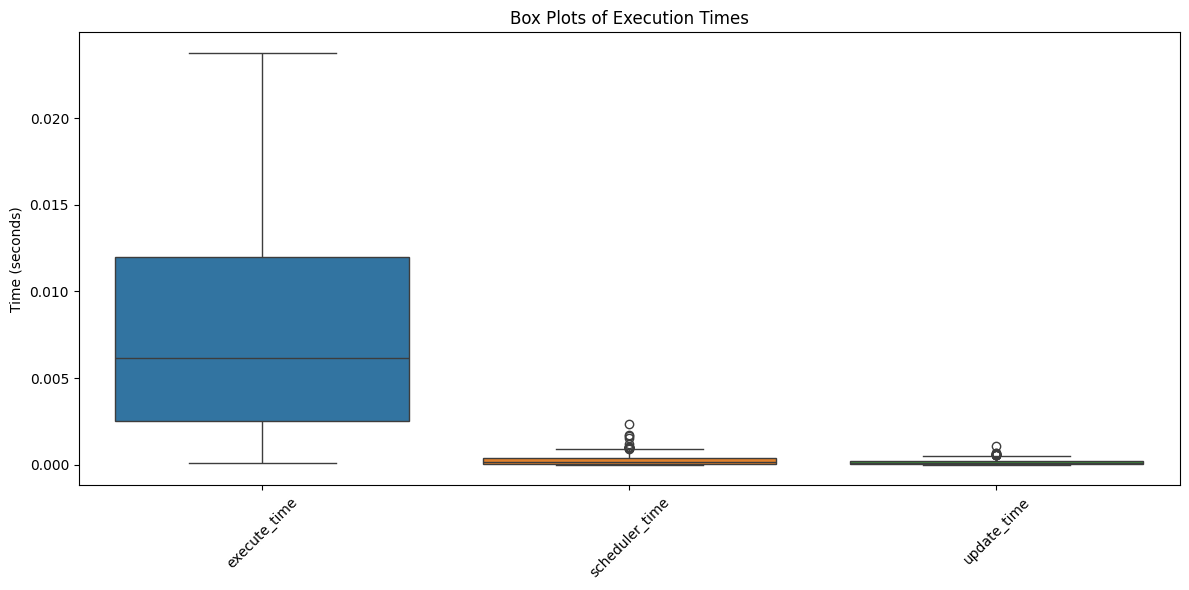

In [11]:
# create box plots for 'execute_time', 'scheduler_time', and 'update_time'
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['execute_time', 'scheduler_time', 'update_time']])
plt.title('Box Plots of Execution Times')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()